In [1]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
from sklearn.utils import resample
from IPython.display import display
import numpy as np

# Create a connection with SQL server to get data.
def exec_sql_query(query, param=None):
    
    from sqlalchemy import create_engine
    import urllib
    params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};SERVER=LAPTOP-C3LFVOFI;DATABASE=student_life;UID=student_sense;PWD=abhinav123")
    engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
    connection = engine.raw_connection()
    
    try:
        cursor = connection.cursor()
        if(param):
            cursor.execute(query, param)
        else : 
            cursor.execute(query)
            
        results = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df = pd.DataFrame.from_records(results, columns=columns)
        cursor.close()
        connection.commit()
    finally:
        connection.close()
    
    del engine
    return df

In [2]:
# Fetching EMA data from SQL.
sql = "Exec get_ema_data"
ema = exec_sql_query(sql)
ema.date = pd.to_datetime(ema.date) 

In [3]:
# getting distinct students
distinct_students = ema.student_id.unique()
dates = pd.DataFrame(pd.date_range(start='2013-03-24', end='2013-05-08'), columns=['date'])
dates.reset_index(inplace=True)

for idx ,student in enumerate(distinct_students):
     
    df = pd.merge(dates, ema[ema["student_id"] == student], how='left', on='date')
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    
    
    if idx == 0:
        final_ema = df
    else:
        final_ema = final_ema.append(other=df, ignore_index=True)
        
    
final_ema['unit'] = final_ema.groupby('date').cumcount()+1
final_ema.rename(index=str, columns={"index": "day"}, inplace=True)


display(final_ema.head() ) 

,day,date,student_id,min_stress_level,max_stress_level,avg_stress_level,unit
0,0,2013-03-24,1.0,1.0,4.0,2.0,1
1,1,2013-03-25,1.0,1.0,4.0,2.0,1
2,2,2013-03-26,1.0,1.0,4.0,2.0,1
3,3,2013-03-27,1.0,1.0,1.0,1.0,1
4,4,2013-03-28,1.0,1.0,1.0,1.0,1


In [4]:
# Preparing conditioned data


# Adding avg stress
plotting_data = final_ema.loc[:, ['day','date','student_id', 'unit','avg_stress_level']]
plotting_data.rename(index=str, columns={"avg_stress_level": "stress_level"}, inplace=True)
plotting_data['condition'] = 'avg_stress'

# display(plotting_data.head())

# Adding Min stress
min_stress = final_ema.loc[:, ['day','date','student_id', 'unit','min_stress_level']]
min_stress['condition'] = 'min_stress'
min_stress.rename(index=str, columns={"min_stress_level": "stress_level"}, inplace=True)

# display(min_stress)

plotting_data = plotting_data.append(min_stress, ignore_index=True, )

# display(plotting_data)


# Adding Max stress
max_stress = final_ema.loc[:, ['day','date','student_id', 'unit','max_stress_level']]
max_stress['condition'] = 'max_stress'
max_stress.rename(index=str, columns={"max_stress_level": "stress_level"}, inplace=True)

plotting_data = plotting_data.append(max_stress, ignore_index=True, )


C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


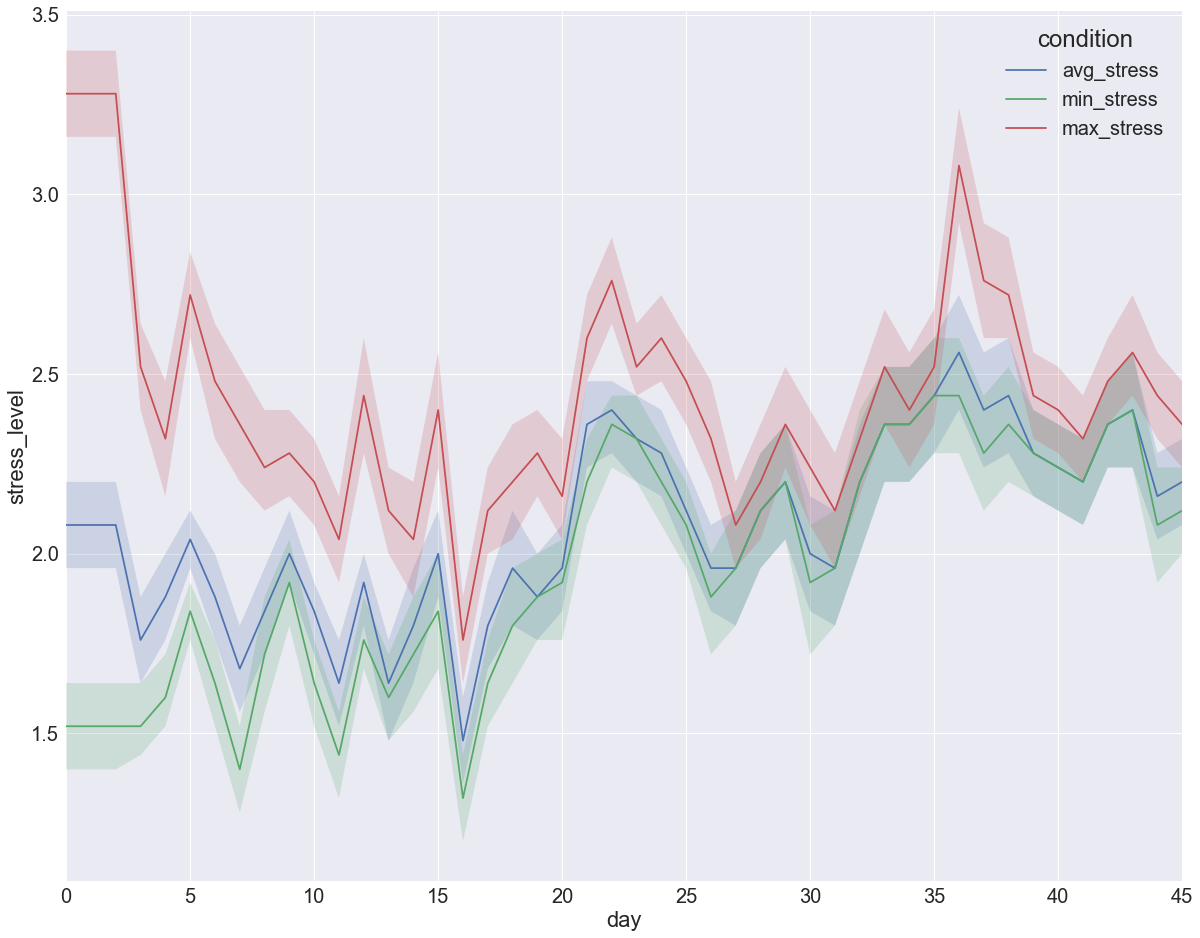

In [7]:
# Producing Ts Plot.
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(20, 16))
plt.subplot()
sns.set_style("dark")
# sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20, "legend.fontsize":16})   
sns.set(font_scale = 2)

ax = sns.tsplot(data=plotting_data, time="day", condition='condition', value='stress_level', unit='unit', ci=50 )

plt.savefig("Plots/ema_viz_all.jpg")


C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


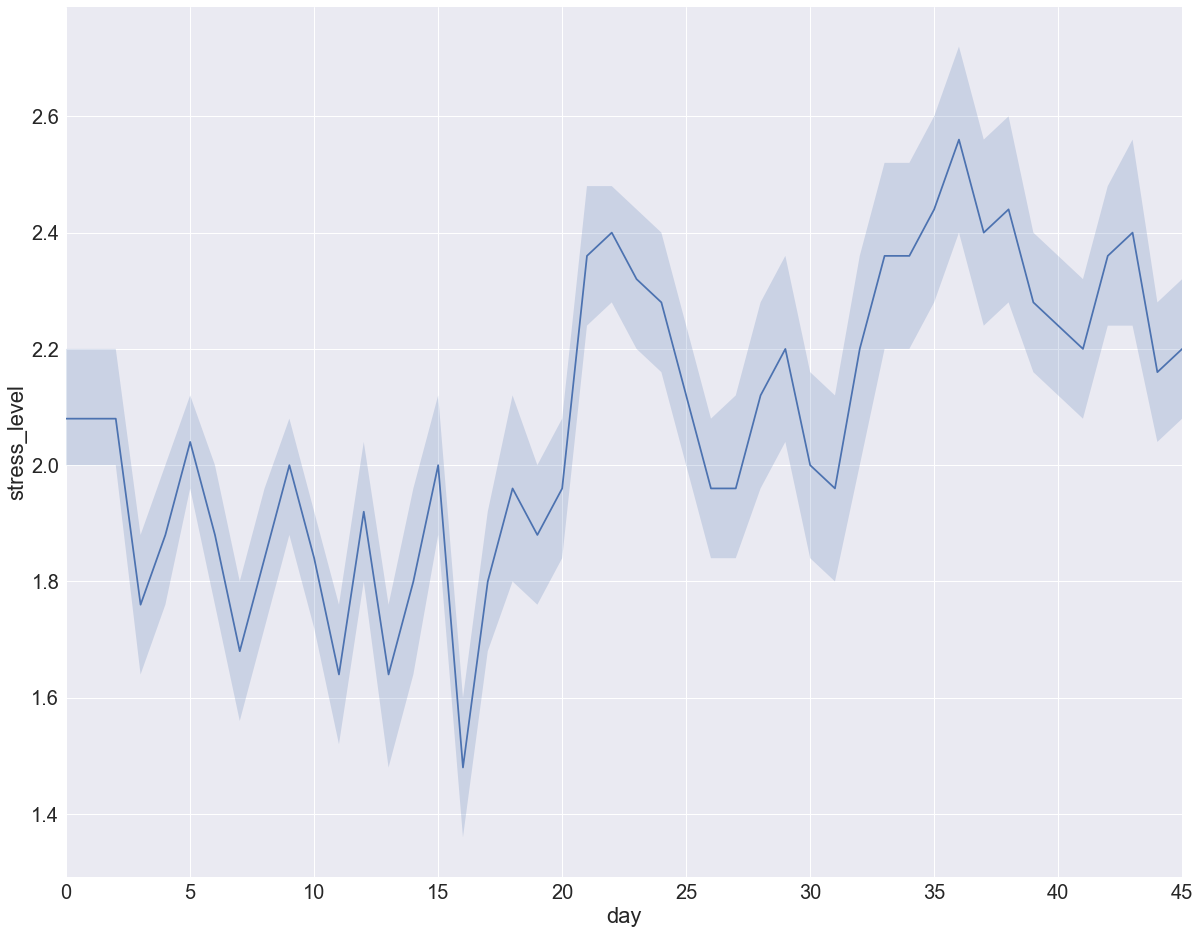

In [12]:
avg_stress = plotting_data[plotting_data.loc[:,'condition'] == 'avg_stress'] 

# display(avg_stress)
plt.figure(figsize=(20, 16))
ax = sns.tsplot(data=avg_stress, time="day",  value='stress_level', unit='unit', ci=50 )

plt.savefig("Plots/ema_viz_avg.jpg")